<img src="img/TJI_logo_whitebg_440x220.jpg" alt="drawing" style="width: 220px;float: right"/>

# Analysis: Shootings and deaths by race and county population
---

## Overview

Generating two custom charts for the homepage, showing raw counts of shooting victims by race or county population.

## Datasets used
* `tji/officer-involved-shooting/shot_civilians`
* `tji/officer-involved-shooting/shot_officers`
* `tji/auxiliary-datasests/census_data_by_county.csv`

##### Author: Everett Wetchler (everett.wetchler@gmail.com)
---

## [ Setup and load data ]

In [1]:
from lib import *
plotsaver = PlotSaver('../plots/', 'ois_counts_by_', numbering=False)

Removing 2 past plots


/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Everett Wetchler 2018-05-27 12:36:07 CDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
seaborn 0.7.1
datadotworld 1.6.0
watermark 1.5.0


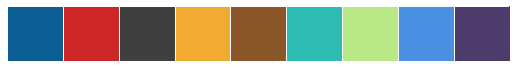

In [2]:
import datetime as dt
import os
import random

import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Jupyter setup
%matplotlib inline

## Graphical setup
mpl.rcParams.update({
  'font.size': 14,
  'font.family': 'Helvetica',
  'axes.titlesize': 'xx-large',
  'axes.labelsize': 'x-large',
  'xtick.labelsize': 'large',
  'ytick.labelsize': 'large',
  'legend.fancybox': True,
  'legend.fontsize': 'large',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
  'lines.linewidth' : 5,
  'lines.solid_joinstyle': 'miter',
})

TJI_BLUE = '#0B5D93'
TJI_RED = '#CE2727'
TJI_DARKGRAY = '#3F3F40'
TJI_YELLOW = '#F1AB32'
TJI_BROWN = '#8B572A'
TJI_TEAL = '#2EBBB1'
TJI_LIGHTGREEN = '#B8E986'
TJI_LIGHTBLUE = '#4A90E2'
TJI_PURPLE = '#4D3B6B'
TJI_PALETTE = sns.color_palette([
    TJI_BLUE,
    TJI_RED,
    TJI_DARKGRAY,
    TJI_YELLOW,
    TJI_BROWN,
    TJI_TEAL,
    TJI_LIGHTGREEN,
    TJI_LIGHTBLUE,
    TJI_PURPLE,
])

sns.set_palette(TJI_PALETTE)
sns.palplot(TJI_PALETTE)

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -d -t -z -w -p numpy,pandas,matplotlib,seaborn,datadotworld

In [3]:
import matplotlib.font_manager as fm
# CUSTOM_FONT = fm.FontProperties(fname='font/CUSTOM_FONT_500.otf')

In [4]:
datasets = dw.load_dataset('tji/officer-involved-shootings', force_update=True)
shot_civ = datasets.dataframes['shot_civilians']
shot_ofc = datasets.dataframes['shot_officers']

first_shooting = shot_civ.date_incident.min().strftime('%Y-%m-%d')
last_shooting = shot_civ.date_incident.max().strftime('%Y-%m-%d')
print("OIS data from %s to %s" % (first_shooting, last_shooting))

OIS data from 2015-09-02 to 2018-05-14


## Helper code

In [5]:
def adjust(df, order=None):
    df = df.copy()
    df.columns = ['injured', 'killed']
    for c in df.columns:
        df[c] = df[c]
    df['total'] = (df['injured'].fillna(0) + df['killed'].fillna(0))
    df['injured_frac'] = df['injured'].div(df['total'])
    df['killed_frac'] = df['killed'].div(df['total'])
    df.columns.name = None
    df.index.name = None
    if order:
        df = df.loc[order, :]
    return df.fillna(0)

def get_frames(category, cat_order=None, prefix=True):
    dfc = shot_civ.groupby([shot_civ[('civilian_' if prefix else '') + category], shot_civ.civilian_died]).size().unstack()
    dfc = adjust(dfc, cat_order)
    dfo = shot_ofc.groupby([shot_ofc[('officer_' if prefix else '') + category], shot_ofc.officer_died]).size().unstack()
    dfo = adjust(dfo, cat_order)
    return dfc, dfo

In [6]:
COLOR_INJURED = TJI_BLUE
COLOR_KILLED = TJI_RED
BAR_HEIGHT = 1
BARSPREAD = BAR_HEIGHT * 3
TITLE_SIZE = 40
LEGEND_SIZE = 24
CATEGORY_SIZE = 32
PERSON_SIZE = 24
CIV_ALPHA = 1.0

def make_chart(category, dfc, dfo, title_by):
    sns.set_style("white")
    
    N_CATEGORIES = max(len(dfc), len(dfo))

    fig, ax = plt.subplots(1, frameon=False)
    fig.set_size_inches(20, N_CATEGORIES * 3)
    plt.subplots_adjust(left=0.35, right=.95)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='x', alpha=0.7)
    ax.yaxis.set_visible(False)
    
    ax.set_xlim(0, max([dfc['total'].max(), dfo['total'].max()]))
    xrange = ax.get_xlim()[1] - ax.get_xlim()[0]
    ax.set_ylim(-BAR_HEIGHT, BARSPREAD * N_CATEGORIES + BAR_HEIGHT)
    yrange = ax.get_ylim()[1] - ax.get_ylim()[0]
    xyratio = xrange / yrange
    
    bar_height_frac = BAR_HEIGHT / yrange
    x_count = -bar_height_frac * xrange * 0.6
    x_person = -bar_height_frac * xrange * 4.25
    x_category = -bar_height_frac * xrange * 5

    for df in [dfc, dfo]:
        offset = 0
        alpha = 1.0
        person = 'OFFICERS SHOT'
        if df is dfc:
            offset = BAR_HEIGHT * 1.05
            alpha = CIV_ALPHA
            person = 'CIVILIANS SHOT'
        for i, category in enumerate(reversed(df.index)):
            y = (i * BARSPREAD) + offset
            text_y = y + (BAR_HEIGHT / 2.0)
            labels = [None, None]
            if df is dfc and i == 0:
                labels = ['Killed', 'Injured']
            # Stacked bars for injured and killed persons
            ax.barh(y, df.loc[category, 'killed'], HEIGHT=BAR_HEIGHT, color=COLOR_KILLED,
                    alpha=alpha, label=labels[0], align='edge')
            ax.barh(y, df.loc[category, 'injured'], HEIGHT=BAR_HEIGHT,color=COLOR_INJURED,
                    alpha=alpha, label=labels[1], align='edge', left=df.loc[category, 'killed'])
            # Label for 'CIVILIANS SHOT' (or 'OFFICERS SHOT')
            ax.text(x_person, text_y, person, horizontalalignment='left', verticalalignment='center',
                    fontsize=PERSON_SIZE)
            # Label for the number of persons shot
            ax.text(x_count, text_y, '(%d)' %  df.loc[category, 'total'], 
                    horizontalalignment='center', verticalalignment='center',
                    fontsize=PERSON_SIZE)
            if df is dfc:
                # Text for category
                ax.text(x_category, text_y - offset/2, category,
                        horizontalalignment='right', verticalalignment='center',
                        fontsize=CATEGORY_SIZE, fontweight='bold',
                        bbox=dict(facecolor=sns.color_palette()[i],
                                  edgecolor='black', linewidth=2,
                                  pad=20, alpha=0.5)
                       )

    ax.text(ax.get_xlim()[1] * 1/8, ax.get_ylim()[1],
            'TX Officer-involved shootings:\nPersons shot since Sept 2015',
            fontsize=TITLE_SIZE, fontweight='bold',
            horizontalalignment='center', verticalalignment='bottom')
    ax.legend(loc='center right', bbox_to_anchor=(1.0, 1.0), fontsize=LEGEND_SIZE,
              ncol=1, borderpad=1, framealpha=1.0, facecolor=[.95]*3, frameon=True)
    return fig, ax

----
## OIS by race
----

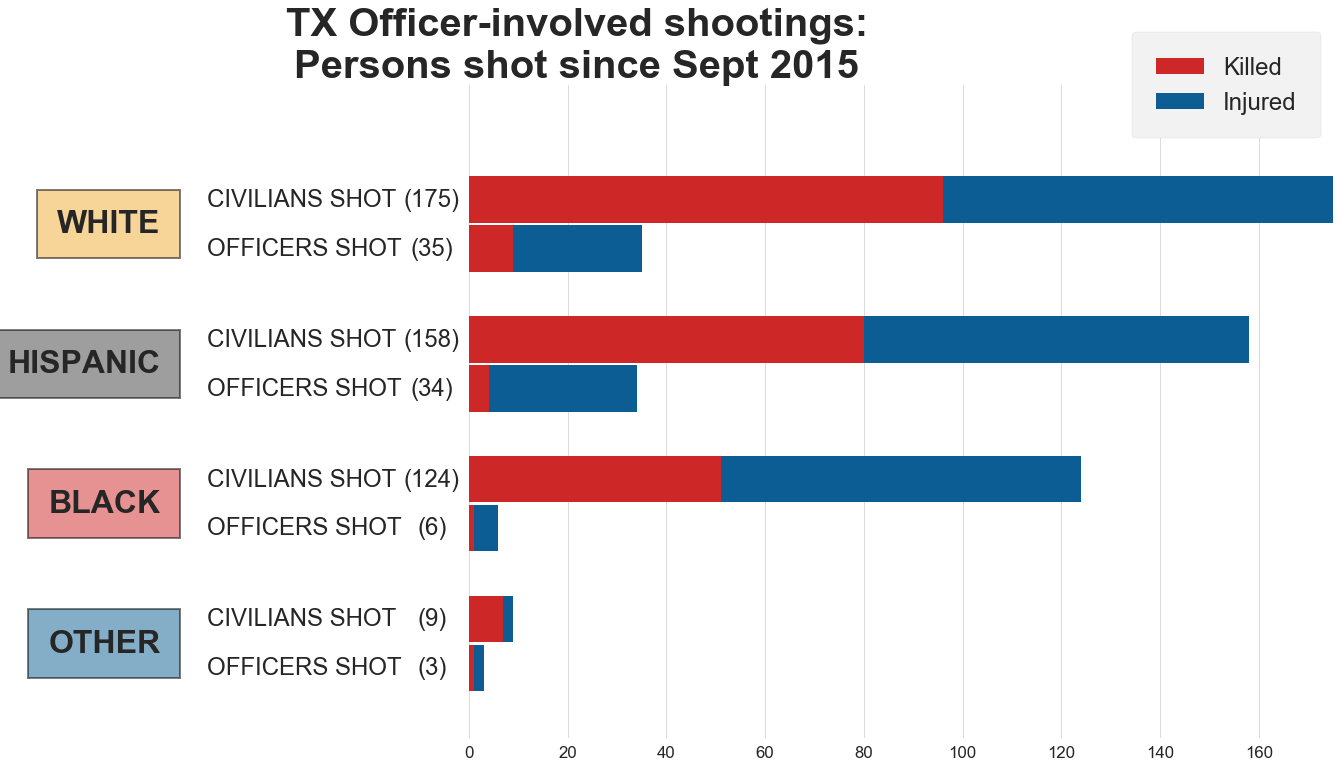

In [7]:
dfc, dfo = get_frames('race', ['WHITE', 'HISPANIC', 'BLACK', 'OTHER'])
fig, ax = make_chart('race', dfc, dfo, title_by='race')
plotsaver.saveplot(fig, 'race')

----
## OIS by county urbanization (population)
----

In [8]:
datasets = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
census = datasets.dataframes['census_data_by_county']
census.set_index('metric_description', inplace=True)
census.drop([c for c in census.columns if c.startswith('metric_')], inplace=True, axis=1)
census.columns = [c.upper() for c in census.columns]
census = census.T
population = census['Population estimates, July 1, 2017,  (V2017)'].to_dict()

In [9]:
for df in (shot_civ, shot_ofc):
    df.drop([c for c in df.columns if c == 'incident_county_population'], axis=1, inplace=True)
    df['incident_county_population'] = df['incident_county'].apply(lambda c: population.get(c.replace(' ', '_'), np.nan))

In [10]:
print("Missing county population for %d shot civilians and %d shot officer" % (
    shot_civ.incident_county_population.isnull().sum(),
    shot_ofc.incident_county_population.isnull().sum()))

Missing county population for 2 shot civilians and 0 shot officer


In [11]:
def pop_category(pop):
    if pop < 2500:
        return 'RURAL AREAS\n(< 2,500 pop.)'
    elif pop < 50000:
        return 'URBAN CLUSTERS\n(2,500 - 50,000 pop.)'
    else:
        return 'URBAN AREAS\n(50,000+ pop.)'

for df in (shot_civ, shot_ofc):
    df['incident_county_population_category'] = df['incident_county_population'].apply(pop_category)

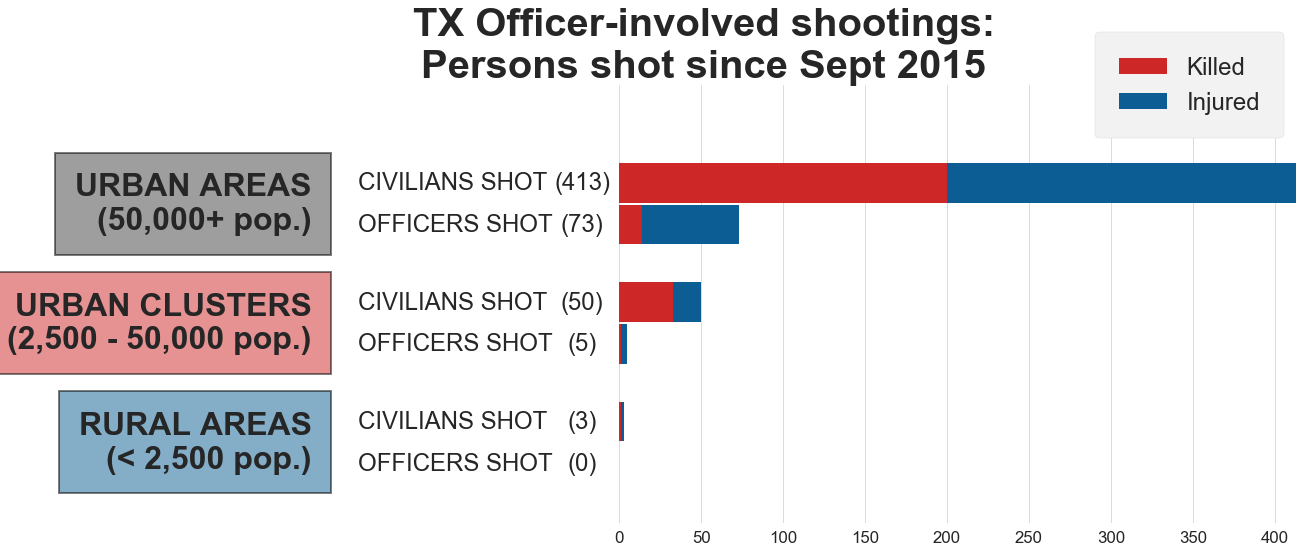

In [12]:
dfc, dfo = get_frames('incident_county_population_category', [pop_category(i) for i in (50001, 2501, 0)], prefix=False)

fig, ax = make_chart('incident_county_population_category', dfc, dfo, title_by='county urbanization')
fig.set_size_inches(fig.get_size_inches()[0], fig.get_size_inches()[1])
plt.subplots_adjust(left=0.48, top=0.8, right=0.95)
plotsaver.saveplot(fig, 'urbanization')